# Finding objects via template matching

Finding an object in the image isn't a simple task, due to various representations the same instance may look dramatically different, and at first sight, some complicated computer vision algorithms are required. But, if we limit the issue, the task may be successfully solved by relatively simple methods. In this recipe, we consider the methods for finding objects on the image which correspond to some of the template.

`cv2.matchTemplate` is used to find image regions that are similar to the template. The similarity can be determined with different methods (different mathematical operations to get the difference between the template and a patch on the image). But, none of these methods are able to find templates with different scales or orientations.

This function takes source image, search template, and the method of patch and template comparison. The methods are determined by these values: `cv2.TM_CCOEFF`, `cv2.TM_CCOEFF_NORMED`, `cv2.TM_CCORR`, `cv2.TM_CCORR_NORMED`, `cv2.TM_SQDIFF` or `cv2.TM_SQDIFF_NORMED`. The methods with `CCOEFF` in the name use correlation coefficient computation, like the similarity measure - the bigger the value, the more similar the regions are. The methods with `CCORR` use cross-correlation computation to compare patches, and the methods with `SQDIFF` find the square difference between the regions to compare them.

The function returns the distribution of the selected similarity metric across the input image. The returned image is a single-channel floating point, with a spatial size (`W-w+1`, `H-h+1`), where capital letters stand for input image dimensions and small letters are for template dimensions. The content of the returned image depends on the method we use, for approaches with correlation computation, a bigger value means better matching. And, as the name implies, the methods with square difference usage have the smallest values as perfect matches.

Methods which use correlation coefficient computation give the fewest mismatches, but require more computation. Square difference methods take less computation, but also give less reliable results. This can be application for small and/or featureless patches, as shown on the second image that follows.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S04\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s04\env

d:\html_doc\program\opencv\packt\s04\env\lib\site-packages
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython


Load image and define mouse callback function for selecting image ROI. What is inside of the rectangle that is drawn will be our template for matching:

In [2]:
# Load image and define mouse callback function for selecting image ROI
img = cv2.imread('../data/Lena.png', cv2.IMREAD_COLOR)
show_img = np.copy(img)

mouse_pressed = False
y = x = w = h = 0

def mouse_callback(event, _x, _y, flags, param):
    global show_img, x, y, w, h, mouse_pressed

    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_pressed = True
        x, y = _x, _y
        show_img = np.copy(img)

    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_pressed:
            show_img = np.copy(img)
            cv2.rectangle(show_img, (x, y),
                          (_x, _y), (0, 255, 0), 2)

    elif event == cv2.EVENT_LBUTTONUP:
        mouse_pressed = False
        w, h = _x - x, _y - y

Display the image, select an object to find with the mouse, and press the **A** button to finish the process and get the template:

In [3]:
# Display the image, select an object to find with the mouse
cv2.namedWindow('select an object and press the A')
cv2.setMouseCallback('select an object and press the A', mouse_callback)

while True:
    cv2.imshow('select an object and press the A', show_img)
    k = cv2.waitKey(1)

    if k == ord('a') and not mouse_pressed:
        if w*h > 0:
            break

cv2.destroyAllWindows()

template = np.copy(img[y:y+h, x:x+w])

Show the image and handle button press events. Digits from `0` to `5` determine the method we use to find areas on the image which are similar to the template. The matching is performed with the cv2.matchTemplate function. When the matching is finished, we find the points with the highest (or the lowest) similarity metric and draw detection results:

In [4]:
#Функцию поиска можно приблизительно представить следующим образом:
# изображение шаблона templ последовательно накладывается на исходное изображение image и 
# между ними вычисляется корреляция, результат которой заносится в результирующее изображение result.
#Очевидно, что корреляцию между двумя изображениями можно считать разными способами.
# Эти методы собраны выше в перечислении и просто меняют формулу рассчёта корреляции:
    
#cv2.matchTemplate(image, templ, method[, result]) -> result
# image — изображение для поиска (8-битное или 32F)
# templ — шаблон для поиска (не должен превышать исходное изображение и иметь тот же тип)
# result — карта результата сравнения (32FС1) если image WxH и templ wxh, то result = (W-w+1)x(H-h+1)
# method — метод сравнения областей изображения:

# Show the image and handle button press events
# Digits from 0 to 5 determine the method we use 
# to find areas on the image which are similar to the template
methods = ['cv2.TM_CCOEFF', 
           'cv2.TM_CCOEFF_NORMED', 
           'cv2.TM_CCORR',
           'cv2.TM_CCORR_NORMED', 
           'cv2.TM_SQDIFF', 
           'cv2.TM_SQDIFF_NORMED']
images =[]
show_img = np.copy(img)

In [5]:

while True:
    cv2.imshow('select an object and press the A', show_img)
    k = cv2.waitKey()

    if k == 27:
        break
    elif k > 0 and chr(k).isdigit():
        index = int(chr(k))
        if 0 <= index < len(methods):
            method = methods[index]
            
            res = cv2.matchTemplate(img, template, eval(method))
            res = cv2.normalize(res, None, 0, 1, cv2.NORM_MINMAX)
            
            if index >= methods.index('cv2.TM_SQDIFF'):
                loc = np.where(res < 0.01)
            else:
                loc = np.where(res > 0.99)
            
            show_img = np.copy(img)
            for pt in zip(*loc[::-1]):
                cv2.rectangle(show_img, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
            
            res = cv2.resize(res, show_img.shape[:2])*255
            res = cv2.cvtColor(res, cv2.COLOR_GRAY2BGR).astype(np.uint8)
            cv2.putText(res, method, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            
            show_img = show_img #np.hstack((show_img, res))

cv2.destroyAllWindows()

1 cv2.TM_CCOEFF


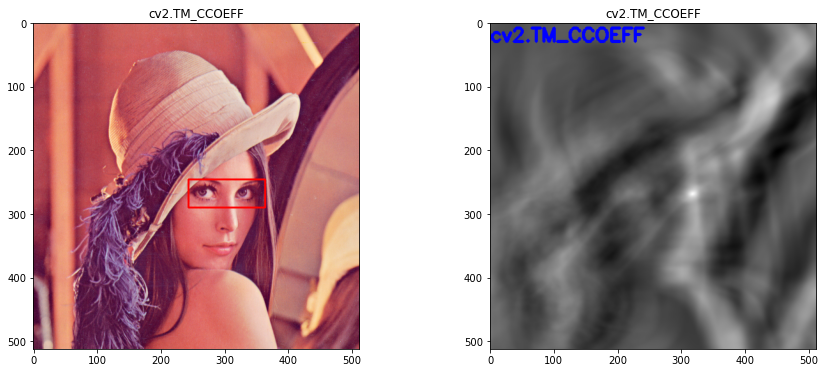

2 cv2.TM_CCOEFF_NORMED


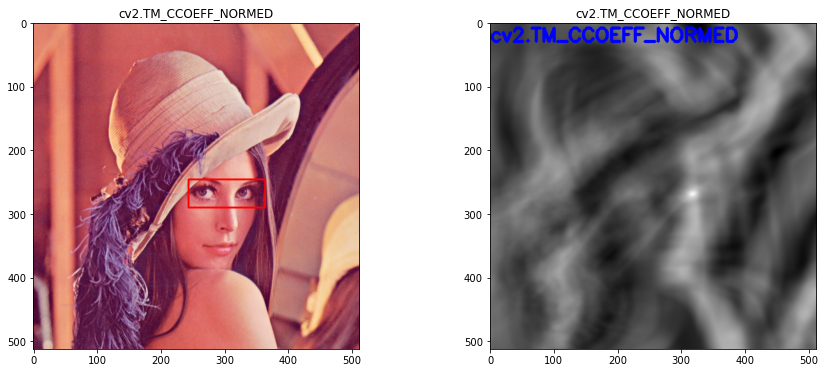

3 cv2.TM_CCORR


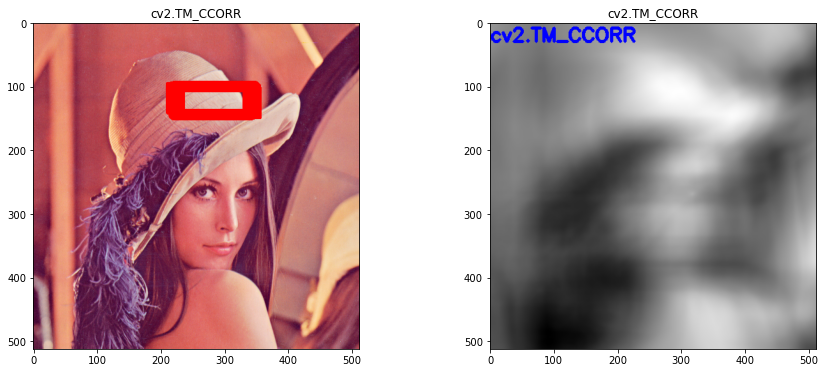

4 cv2.TM_CCORR_NORMED


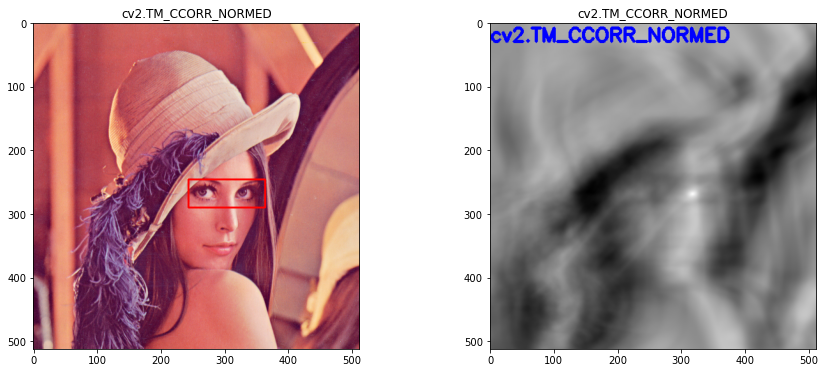

5 cv2.TM_SQDIFF


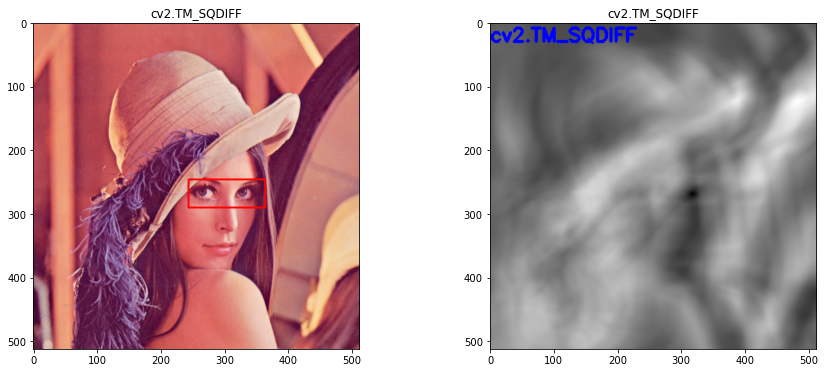

6 cv2.TM_SQDIFF_NORMED


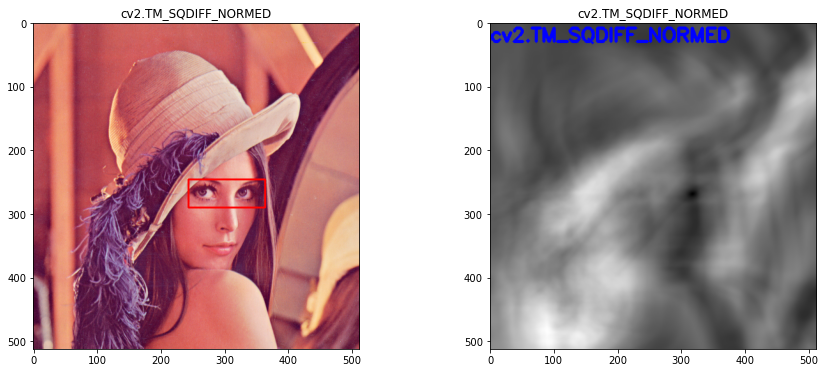

In [6]:
j = 0
for current in ['cv2.TM_CCOEFF','cv2.TM_CCOEFF_NORMED','cv2.TM_CCORR','cv2.TM_CCORR_NORMED']:
    images =[]
    name_method = current;  j +=1;  print(j, name_method)
    
    res = cv2.matchTemplate(img, template, eval(name_method))
    res = cv2.normalize(res, None, 0, 1, cv2.NORM_MINMAX)
    # index < methods.index('cv2.TM_SQDIFF'):
    loc = np.where(res > 0.99)
    
    show_img = np.copy(img)
    for pt in zip(*loc[::-1]):
        cv2.rectangle(show_img, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
            
    res = cv2.resize(res, show_img.shape[:2])*255
    res = cv2.cvtColor(res, cv2.COLOR_GRAY2BGR).astype(np.uint8)
    cv2.putText(res, name_method, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
    
    images.append([name_method,show_img[:,:,[2,1,0]]])
    images.append([name_method,res])
    show_img = show_img
    plt_view_image(plt,images, figsize=(15,6), axis='on', cmap='gray')

##########################################################
for current in ['cv2.TM_SQDIFF','cv2.TM_SQDIFF_NORMED']:
    images =[]
    name_method = current;  j +=1;  print(j, name_method)
    
    res = cv2.matchTemplate(img, template, eval(name_method))
    res = cv2.normalize(res, None, 0, 1, cv2.NORM_MINMAX)
    # index => methods.index('cv2.TM_SQDIFF'):
    loc = np.where(res < 0.01)
    
    show_img = np.copy(img)
    for pt in zip(*loc[::-1]):
        cv2.rectangle(show_img, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
            
    res = cv2.resize(res, show_img.shape[:2])*255
    res = cv2.cvtColor(res, cv2.COLOR_GRAY2BGR).astype(np.uint8)
    cv2.putText(res, name_method, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
    
    images.append([name_method,show_img[:,:,[2,1,0]]])
    images.append([name_method,res])
    show_img = show_img
    plt_view_image(plt,images, figsize=(15,6), axis='on', cmap='gray')